In [72]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew


train_path = "./house-prices-advanced-regression-techniques/train.csv"
test_path ="./house-prices-advanced-regression-techniques/test.csv"

In [46]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.head(5)
# test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [26]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [47]:
#把id去掉
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


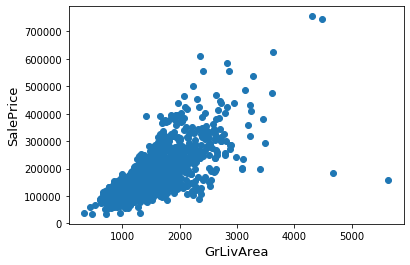

In [48]:
# 處理前數據的分佈, 加x,y軸Label
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()


In [49]:
# 刪掉下面兩個異常數據 (train['GrLivArea']>4000) & (train['SalePrice']<300000)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


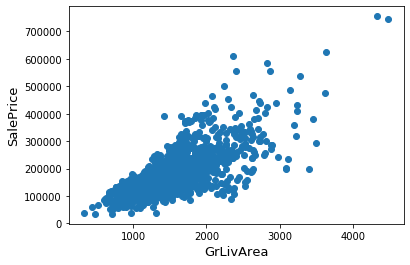

In [50]:
# 處理後數據的分佈, 加x,y軸Label
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)

plt.show()

In [73]:
#SalePrice特徵處理


 mu=180932.92 and sigma=79467.79 



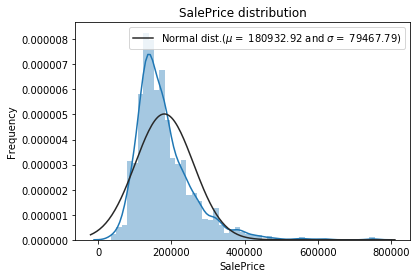

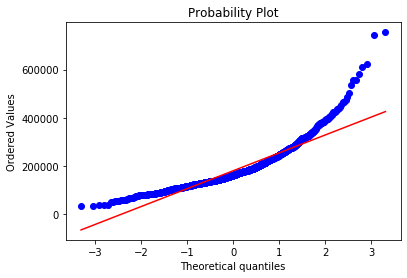

In [76]:
# 處理前數據的分佈, 加x,y軸Label

sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))
#下圖表標注
plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()





In [ ]:
# 數據的偏度大, 用log1p處理(log(X+1)), 使其更加服從高斯分佈。
# 最後需要將預測出的平滑數據進行還原，而還原過程就是log1p的逆運算expm1

In [77]:
train['SalePrice'] = np.log1p(train['SalePrice'])


 mu=12.02 and sigma=0.40 



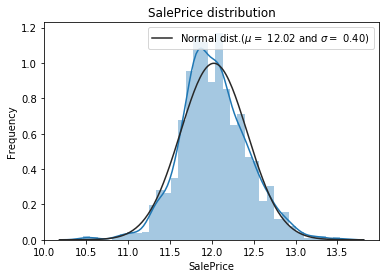

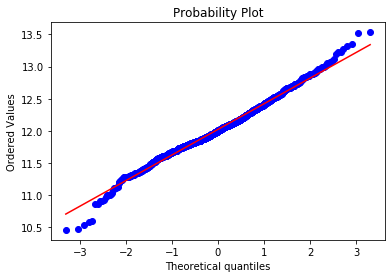

In [78]:
# 處理後數據的分佈, 加x,y軸Label

sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu={:.2f} and sigma={:.2f} \n'.format(mu, sigma))
#下圖表標注
plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
stats.probplot(train['SalePrice'], plot=plt)
plt.show()





In [ ]:
特徵處理


In [79]:
#數據集連接
ntrain = train.shape[0]
ntest = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (2917, 79)


In [ ]:
#數值缺失分析

In [80]:
all_data.isnull().head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [81]:
all_data.isnull().sum().head()

1stFlrSF           0
2ndFlrSF           0
3SsnPorch          0
Alley           2719
BedroomAbvGr       0
dtype: int64

In [90]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

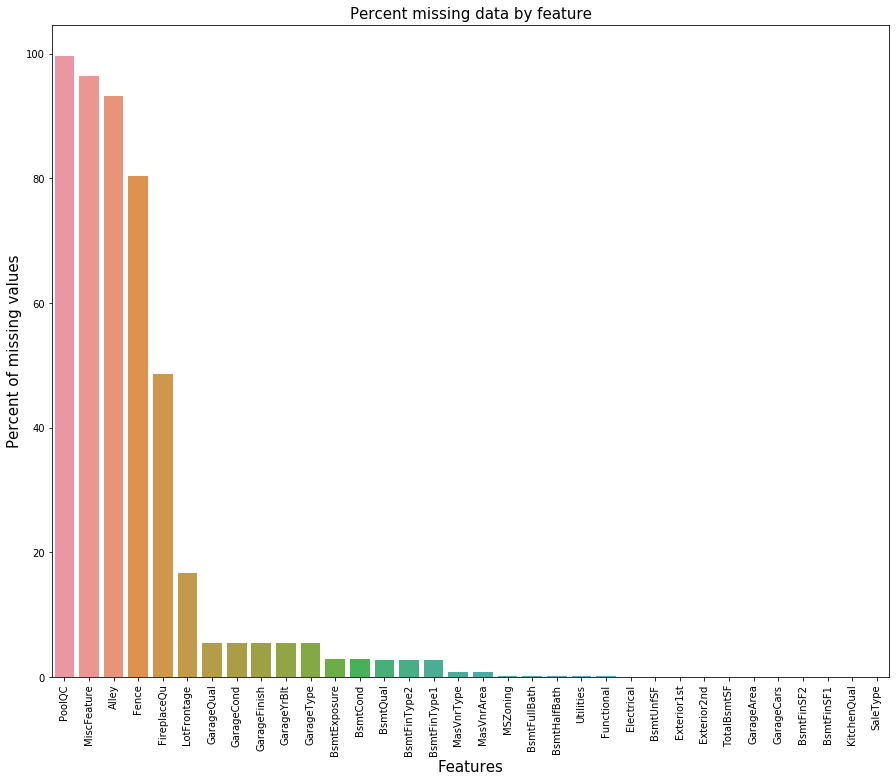

In [91]:

# 含有缺失值的特徵的缺失率

f, axis = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [ ]:

數據相關性

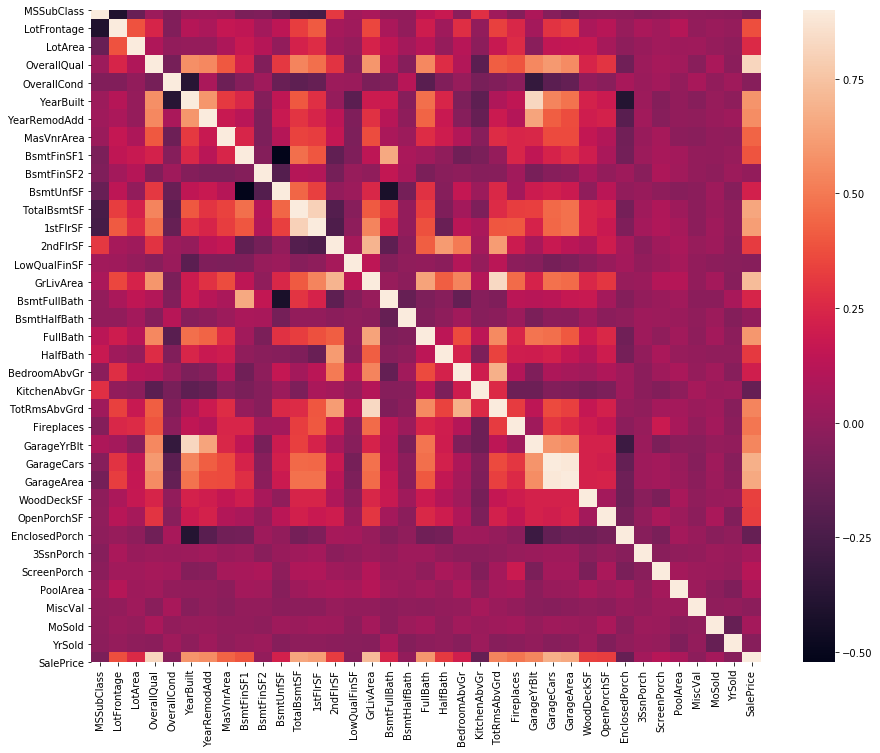

In [92]:
# 全部數值特徵


corrmat = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
# 相關性最大的10個特徵


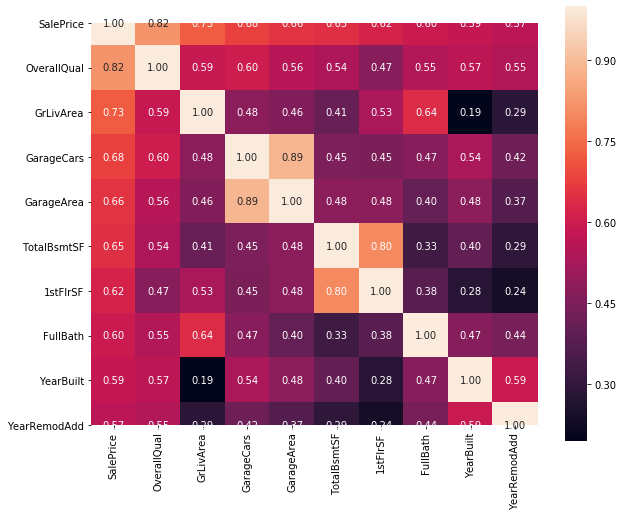

In [93]:
corrmat = train.corr()
plt.subplots(figsize=(10,8))
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


In [ ]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)